<a href="https://colab.research.google.com/github/Jiyanshi021/NLP/blob/main/CountVectorizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  CountVectorizer

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB #classifier of choice
from sklearn.model_selection import train_test_split
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer , PorterStemmer
from nltk.corpus import wordnet


In [ ]:
nltk.download("wordnet")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/nlp//bbc_text_cls.csv

--2024-08-22 04:49:54--  https://lazyprogrammer.me/course_files/nlp//bbc_text_cls.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085081 (4.8M) [text/csv]
Saving to: ‘bbc_text_cls.csv’

bbc_text_cls.csv    100%[===================>]   4.85M  4.73MB/s    in 1.0s    

2024-08-22 04:49:56 (4.73 MB/s) - ‘bbc_text_cls.csv’ saved [5085081/5085081]



In [ ]:
df = pd.read_csv('bbc_text_cls.csv')

In [ ]:
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [ ]:
# assign the two columns to separate variable
inputs = df['text']
labels = df['labels']

##### Plot a histogram of our labels. The point of this is to see whether or not we have imbalanced classes. That is if any class is over  or underrepresented , This can be issue when we check model's performance.

<Axes: >

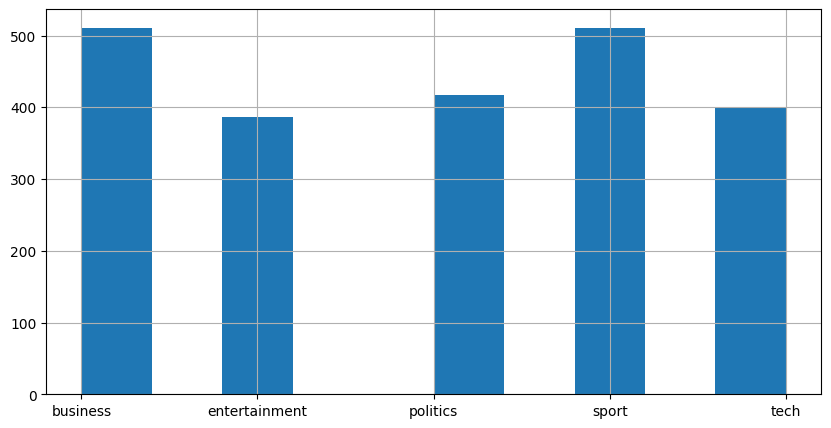

In [ ]:
labels.hist(figsize = (10,5))

Data is not unbalanced . There is no need to check alternative metrices . ALso , this gives a chance to see what labels are working with.

In [ ]:
# Train Test Split
inputs_train, inputs_test , Ytrain , Ytest = train_test_split(inputs , labels , random_state=123)

In [ ]:
vectorizer = CountVectorizer()

In [ ]:
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

###Recall why we are doing this?
Our input data is text but Machine Learning only works on numbers. We have just converted our text into vectors of numbers.
Specefically , Xtrain and Xtest are matrices with number of rows equal to number of data samples and number of columns equal to vocabulary size.

In [ ]:
Xtrain

<1668x26287 sparse matrix of type '<class 'numpy.int64'>'
	with 337411 stored elements in Compressed Sparse Row format>

As you can see Xtrain is not what we may have expected , We expected to see an array of numbers since that what Xtrain is , but instead we see something else.We see that Xtrain is a sparse matrix . As you recall , the reason these special types of matrices are used is because most of the values in the matrix are 0. That is , most documents do not make use of most words. Using a sparse matrix representation is more efficient.
Also note the size of the matrix , there are something 1600 rows and some 26000 columns . Note that this is undesirable in machine learning.
We normally like to have many more rows compared to columns.

Now , to see just how sparse this matrix is, we are going to compute the percentage of values in extreme which are non-zero.  

In [ ]:
(Xtrain !=0).sum()

337411

In [ ]:
# What percentage of value is non zero ?
(Xtrain !=0).sum()/np.prod(Xtrain.shape)

0.007695239935415004

As you can see , less than one percent of the Matrix contains non-zero values , thus we are justified in using a sparse representation. Now , In the next block of code , we would like to do our usual machine learning steps.

In [ ]:
model = MultinomialNB()
model.fit(Xtrain , Ytrain)
print("train score: " , model.score(Xtrain , Ytrain))
print("test score: " , model.score(Xtest , Ytest))

train score:  0.9922062350119905
test score:  0.9712746858168761


Multinomial Naive Bayes (MultinomialNB) is a variant of the Naive Bayes algorithm, particularly suited for classification tasks involving discrete features, such as text classification problems. It's one of the most popular algorithms for tasks like spam detection, sentiment analysis, and document classification.

In [ ]:
# with stopwords
vectorizer = CountVectorizer(stop_words = 'english')
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)
model = MultinomialNB()
model.fit(Xtrain , Ytrain)
print("train score :", model.score(Xtrain , Ytrain))
print("test score: ", model.score(Xtest, Ytest))

train score : 0.9928057553956835
test score:  0.9766606822262118


Our performance is nearly the same as before. The next experiment in this notebook is to use lemmatization. Now bcoz we are using count_vectorizer class in Scikit Learn , This is mainly an exercise in figuring out how to work with the API to use an external tokenize error.We will begin by defining a function that will map parts of speech tags in nltk.

In [ ]:
def get_wordnet_pos(treebank_tag):
  if treebank_tag.startswith('J'):
    return wordnet.ADJ
  elif treebank_tag.startswith('V'):
    return wordnet.VERB
  elif treebank_tag.startswith('N'):
    return wordnet.NOUN
  elif treebank_tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN

The get_wordnet_pos function is a helper function designed to convert the part-of-speech (POS) tags from the Penn Treebank tag set (used by tools like NLTK's pos_tag) to the corresponding WordNet POS tags. This conversion is necessary when performing tasks like lemmatization in NLP, as WordNet requires specific POS tags (ADJ, VERB, NOUN, ADV) to function correctly.

The next block of code is used to define a class called LemmaTokenizer. Basically , this is going to do all the work of tokenizing and lemmatizing each document. Although the syntax is a bit complex. Pay attention to the high  level idea.

What do we want to do is to create an object and then we want to be able to call that object as if it were a function. We can accomplish that by defining a special call function with two underscores on each side.

###### In the initializer , we start by instantiating a WordNetLemmatizer object. The next step is to look at the call function. This essentially takes in one argument , which is the document to tokenize. Inside the function , We start by calling the word tokenize function from nltk. This will convert our documents into tokens. You can think of this like a fancier version of StringSplit. The next step is to obtain the parts of speech tags. This can be done by calling the object.pos_tag. This returns a list containing tuples , and each tuple contains each word in the document , along with its corresponding tag. The final step is to look through each word and tag pair and to call the lemmatizer function . The output of this is a list containing each lemmatized word in the input document.

In [24]:
class LemmaTokenizer:
  def __init__(self):
    self.wnl = WordNetLemmatizer()
  def __call__(self, doc):
    tokens = word_tokenize(doc)
    words_and_tags = nltk.pos_tag(tokens)
    return [self.wnl.lemmatize(word , pos=get_wordnet_pos(tag))
    for word , tag in words_and_tags]


In [25]:
# LemmaTokenizer with CountVectorizer
# we pass in an object of type lemma tokenizer here for tokenize their doc . Note that this takes in any callable , so an object with call fxn is acceptable.
# A regular fxn would be fine as well

In [27]:
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer())
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)
model = MultinomialNB()
model.fit(Xtrain , Ytrain)
print("train score :" , model.score(Xtrain , Ytrain))
print("test score: " , model.score(Xtest, Ytest))

train score : 0.9922062350119905
test score:  0.9676840215439856


In [28]:
# Lemmatization is the slowest process out of everything we tried in this notebook.
# Now lets try Stemming , which is crude version of Lemmatization.

In [30]:
class StemTokenizer:
  def __init__(self):
    self.porter = PorterStemmer()
  def __call__(self , doc):
    tokens = word_tokenize(doc)
    return [self.porter.stem(t) for t in tokens]

In [33]:
# Stemming with CountVectorizer
vectorizer = CountVectorizer(tokenizer = StemTokenizer())
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)
model = MultinomialNB()
model.fit(Xtrain , Ytrain)
print("train score :" , model.score(Xtrain , Ytrain))
print("test score : " , model.score(Xtest , Ytest ))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


train score : 0.9892086330935251
test score :  0.9694793536804309


In [35]:
# defining the simplest tokenizer which is just a string split
def simple_tokenizer(s):
  return s.split()

# We need to put this into a function , since as you recall the tokenize , their argument must be callable and it must accept a document as input.
# In other words, this function has the same interface as the lemmatizer and stemmer

In [36]:
# string sply tokenizer
vectorizer = CountVectorizer(tokenizer = simple_tokenizer)
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)
model = MultinomialNB()
model.fit(Xtrain , Ytrain)
print("train score : " , model.score(Xtrain , Ytrain))
print("test score : ", model.score(Xtest , Ytest))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


train score :  0.9952038369304557
test score :  0.9712746858168761


In [37]:
# A simple string split is a reasonable choice